In [51]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

Придумать двумерную вероятностную модель для двух классов. Это может быть смесь нормальных распределений (с различными параметрами) с числом компонент, большим чем число классов.

In [52]:
maxX = 7
maxY = 7

def create_grid():
  return np.mgrid[-maxX:maxX:.1, -maxY:maxY:.1]

In [53]:
# Распределение 1
_dist1_comp_1 = multivariate_normal([-2,2], [[7, 0], [-1, 2]])
_dist1_comp_2 = multivariate_normal([2,1], [[4, 1], [1, 2]])

def prob_1(pos):
  return _dist1_comp_1.pdf(pos) + _dist1_comp_2.pdf(pos)

In [54]:
# Распределение 2
_dist2_comp_1 = multivariate_normal([3,0], [[2, 1], [1, 2]])
_dist2_comp_2 = multivariate_normal([0,-2], [[4, 1], [1, 2]])
_dist2_comp_3 = multivariate_normal([-1,-1], [[4, 1], [1, 2]])

def prob_2(pos):
  return _dist2_comp_1.pdf(pos) + _dist2_comp_2.pdf(pos) + _dist2_comp_3.pdf(pos)

In [55]:
x, y = create_grid()
pos = np.dstack((x, y))

In [56]:
maxProb1 = np.max(prob_1(pos))
maxProb2 = np.max(prob_2(pos))

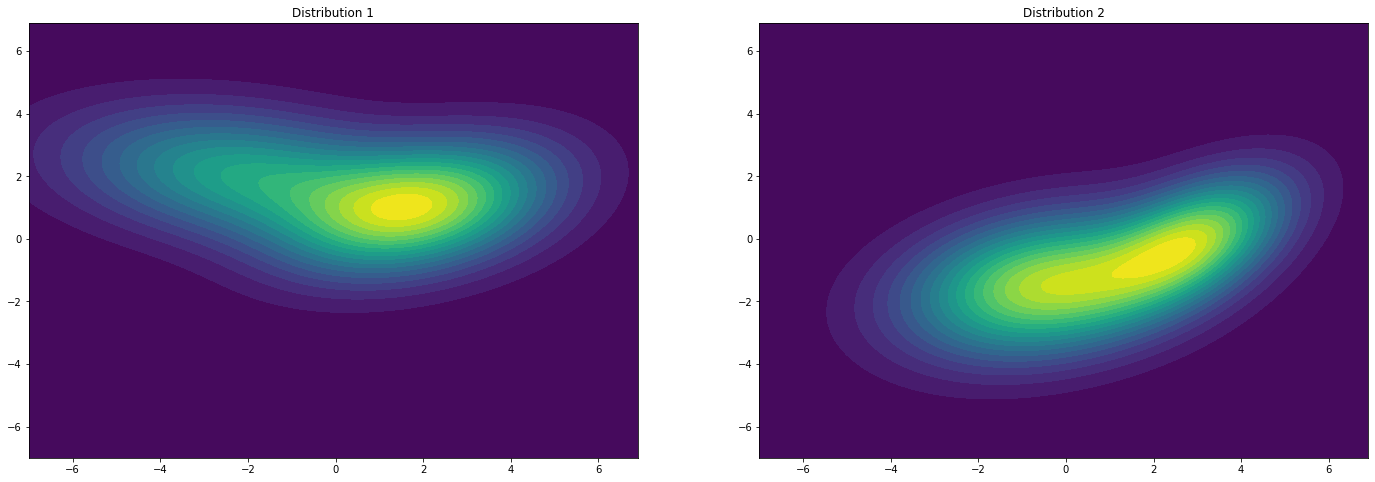

In [57]:
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(121)
ax.set_title('Distribution 1')
cs = ax.contourf(x, y, prob_1(pos) , levels=20)

ax2 = fig.add_subplot(122)
ax2.set_title('Distribution 2')
cs2 = ax2.contourf(x, y, prob_2(pos) , levels=20)

plt.show()

In [58]:
def generate_samples(prob, max_prob, size):
  samples = []
  while len(samples) != size:
    randX = np.random.uniform(-maxX, maxX, 1)[0]
    randY = np.random.uniform(-maxY, maxY, 1)[0]
    randProb = np.random.uniform(0.0, 1.0, 1)[0]
    sample_prob = prob([randX, randY])
    if (sample_prob / max_prob > randProb):
      samples.append([randX, randY])
  return np.array(samples)

samples1 = generate_samples(prob_1, maxProb1, 500)
samples2 = generate_samples(prob_2, maxProb2, 500)

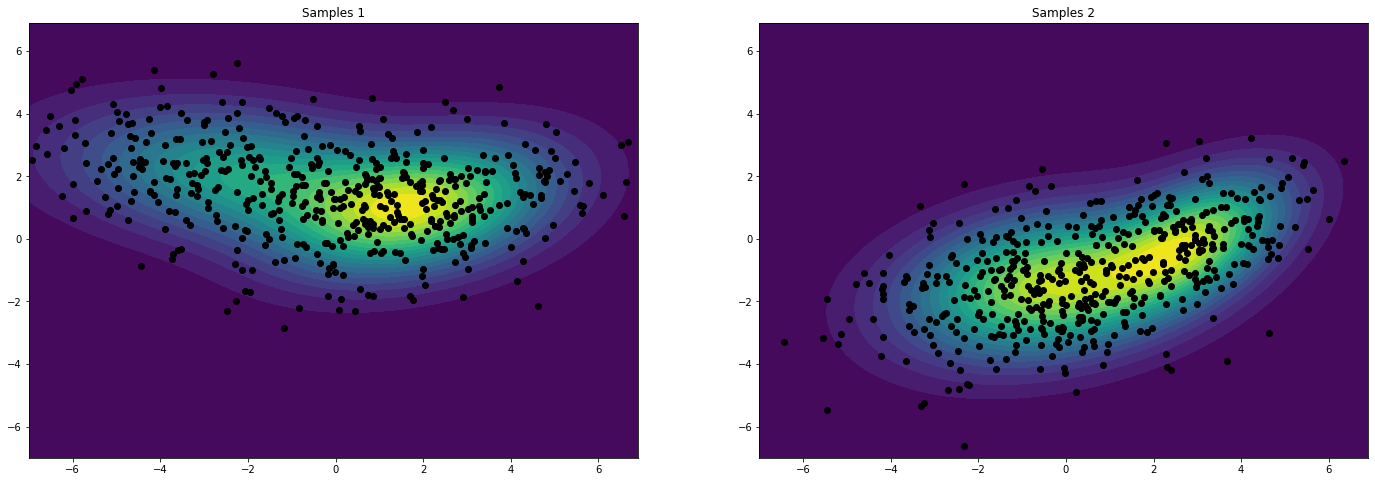

In [59]:
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(121)
ax.set_title('Samples 1')
cs = ax.contourf(x, y, prob_1(pos) , levels=20)
ax.scatter(samples1[:,0],samples1[:,1], c='black')

ax2 = fig.add_subplot(122)
ax2.set_title('Samples 2')
cs2 = ax2.contourf(x, y, prob_2(pos) , levels=20)
ax2.scatter(samples2[:,0],samples2[:,1], c='black')

plt.show()

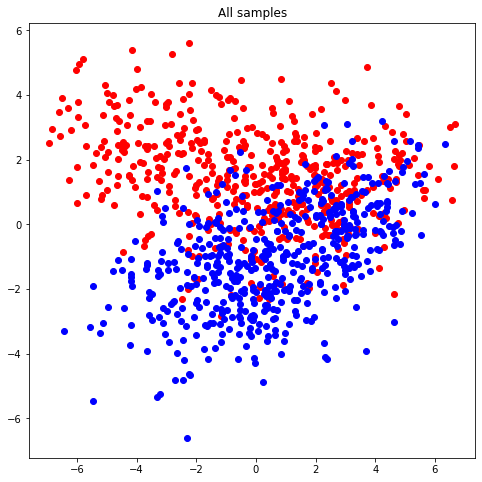

In [60]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title('All samples')
ax.scatter(samples1[:,0],samples1[:,1], c='red')
ax.scatter(samples2[:,0],samples2[:,1], c='blue')
plt.show()